<a href="https://colab.research.google.com/github/jackanichp/Academie/blob/master/Your_first_embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Your first embedding

## Exercise objectives:
- Run your first RNN for NLP
- Get a first taste of what an embedding is

<hr>

Words are not something you can easily feed to a Neural Network. For this reason, we have to convert them to something more meaningful. 

And this is exactly what _Embeddings_ are for! They map any word onto a vectorial representation (this a fancy way to represent each word with a vector ;) ). For instance, the word `dog` can be represented by the vector $(w_1, w_2, ..., w_n)$ in the embedding space, and we will learn the weights $(w_k)_k$.

So let's just do it.


# The data


❓ **Question** ❓ Let's first load the data. You don't have to understand what is going on in the function, it does not matter here.

⚠️ **Warning** ⚠️ The `load_data` function has a `percentage_of_sentences` argument. Depending on your computer, there are chances that too many sentences will make your compute slow down, or even freeze - your RAM can overflow. For that reason, **you should start with 10% of the sentences** and see if your computer handles it. Otherwise, rerun with a lower number. 

⚠️ **DISCLAIMER** ⚠️ **No need to play _who has the biggest_ (RAM) !** The idea is to get to run your models quickly to prototype. Even in real life, it is recommended that you start with a subset of your data to loop and debug quickly. So increase the number only if you are into getting the best accuracy. 

In [1]:
###########################################
### Just run this cell to load the data ###
###########################################

import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.text import text_to_word_sequence

def load_data(percentage_of_sentences=None):
    train_data, test_data = tfds.load(name="imdb_reviews", split=["train", "test"], batch_size=-1, as_supervised=True)

    train_sentences, y_train = tfds.as_numpy(train_data)
    test_sentences, y_test = tfds.as_numpy(test_data)
    
    # Take only a given percentage of the entire data
    if percentage_of_sentences is not None:
        assert(percentage_of_sentences> 0 and percentage_of_sentences<=100)
        
        len_train = int(percentage_of_sentences/100*len(train_sentences))
        train_sentences, y_train = train_sentences[:len_train], y_train[:len_train]
  
        len_test = int(percentage_of_sentences/100*len(test_sentences))
        test_sentences, y_test = test_sentences[:len_test], y_test[:len_test]
    
    X_train = [text_to_word_sequence(_.decode("utf-8")) for _ in train_sentences]
    X_test = [text_to_word_sequence(_.decode("utf-8")) for _ in test_sentences]
    
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = load_data(percentage_of_sentences=10)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteBCDYI7/imdb_reviews-train.tfrecord…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteBCDYI7/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteBCDYI7/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


Now that you have loaded the data, let's check it out!

❓ **Question** ❓ You can play with the data here. In particular, `X_train` and `X_test` are lists of sentences. Let's print some of them, with their respective label stored in `y_train` and `y_test`.

In [ ]:
# YOUR CODE HERE

**LABELS**, the task is a binary classification problem:
- label 0 corresponds to a negative movie review
- label 1 corresponds to a positive movie review

**INPUTS**: The data has been partially cleaned! So you don't have to worry about it in this exercise. But don't forget this step in real-life challenges. 

Remember that words are not computer-compatible materials? You have to tokenize them!

❓ **Question** ❓ Run the following cell to tokenize your sentences

In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer

# This initializes a Keras utilities that does all the tokenization for you
tokenizer = Tokenizer()

# The tokenization learns a dictionary that maps a token (integer) to each word
# It can be done only on the train set - we are not supposed to know the test set!
# This tokenization also lowercases your words, apply some filters, and so on - you can check the doc if you want
tokenizer.fit_on_texts(X_train)
    
# We apply the tokenization to the train and test set
X_train_token = tokenizer.texts_to_sequences(X_train)
X_test_token = tokenizer.texts_to_sequences(X_test)

❓ **Question** ❓ Print some of the tokenized sentences to be sure you got what you expected

In [ ]:
# YOUR CODE HERE

The dictionary that maps each word to a token can be accessed with `tokenizer.word_index`
    
❓ **Question** ❓ Add a `vocab_size` variable that stores the number of different words (=tokens) in the train set. This is called the _size of the vocabulary_.

In [3]:
vocab_size = len(tokenizer.word_index)

Your `X_train_token` and `X_test_token` contain sequences of different lengths.

<img src="padding.png" alt='Word2Vec' width="700px" />

However, a neural network has to have a tensor as input. For this reason, you have to pad your data.

❓ **Question** ❓  Pad your data with the `pad_sequences` function (documentation [here](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences)). Do not forget about the `dtype` and `padding` keywords (but do not use `maxlen` here).

In [4]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
X_pad = pad_sequences(X_train_token, dtype='float32', padding='post')

# The RNN

Let's now feed this data to a Recurrent Neural Network.

❓ **Question** ❓ Write a model that has:
- an embedding layer whose `input_dim` is the size of your vocabulary (= your `vocab_size`), and whose `output_dim` is the size of the embedding space you want to have
- a RNN (SimpleRNN, LSTM, GRU) layer
- a Dense layer
- an output layer

⚠️ **Warning** ⚠️ Here, you don't need a masking layer. Why? Because `layers.Embedding` has a argument to do that directly, which you have to set with `mask_zero=True`. That also means that your data **HAS TO** be padded with **0** (which is the default behavior). See the [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding#example_2) to understand how it **impacts** the `input_dim`.

<details>
    <summary>💡 Hint</summary>

`input_dim` should equal size of vocabulary + 1

</details>

Compile it with the appropriate arguments

In [5]:
from tensorflow.keras import layers, Sequential

embedding_size = 100

model = Sequential()
model.add(layers.Embedding(
    input_dim=vocab_size+1,
    input_length=1164,
    output_dim=embedding_size,
    mask_zero=True, ))

model.add(layers.LSTM(20))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1164, 100)         3042000   
                                                                 
 lstm (LSTM)                 (None, 20)                9680      
                                                                 
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 3,051,701
Trainable params: 3,051,701
Non-trainable params: 0
_________________________________________________________________


❓ **Question** ❓ Look at the number of parameters in your RNN. 

In [6]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'],
              )

❓ Double-check that the number of parameters in your embedding layer is equal to the (number of words in your vocabulary + 1 for the masking value) $\times$  the dimension of your embedding.

In [7]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True
)

history = model.fit(X_pad, y_train, epochs=20, batch_size=16, callbacks=[early_stopping])

Epoch 1/20
157/157 [==============================] - ETA: 0s - loss: 0.6543 - accuracy: 0.6168

157/157 [==============================] - 35s 162ms/step - loss: 0.6543 - accuracy: 0.6168
Epoch 2/20
157/157 [==============================] - ETA: 0s - loss: 0.4210 - accuracy: 0.8172

157/157 [==============================] - 23s 145ms/step - loss: 0.4210 - accuracy: 0.8172
Epoch 3/20
157/157 [==============================] - ETA: 0s - loss: 0.2436 - accuracy: 0.9124

157/157 [==============================] - 19s 119ms/step - loss: 0.2436 - accuracy: 0.9124
Epoch 4/20
157/157 [==============================] - ETA: 0s - loss: 0.1527 - accuracy: 0.9512

157/157 [==============================] - 17s 107ms/step - loss: 0.1527 - accuracy: 0.9512
Epoch 5/20
157/157 [==============================] - ETA: 0s - loss: 0.0930 - accuracy: 0.9688

157/157 [==============================] - 14s 86ms/step - loss: 0.0930 - accuracy: 0.9688
Epoch 6/20
157/157 [==============================] - ETA: 0s - loss: 0.0535 - accuracy: 0.9824

157/157 [==============================] - 13s 81ms/step - loss: 0.0535 - accuracy: 0.9824
Epoch 7/20
157/157 [==============================] - ETA: 0s - loss: 0.0323 - accuracy: 0.9912

157/157 [==============================] - 9s 60ms/step - loss: 0.0323 - accuracy: 0.9912
Epoch 8/20
157/157 [==============================] - ETA: 0s - loss: 0.0119 - accuracy: 0.9976

157/157 [==============================] - 9s 55ms/step - loss: 0.0119 - accuracy: 0.9976
Epoch 9/20
157/157 [==============================] - ETA: 0s - loss: 0.0188 - accuracy: 0.9952

157/157 [==============================] - 9s 55ms/step - loss: 0.0188 - accuracy: 0.9952
Epoch 10/20
157/157 [==============================] - ETA: 0s - loss: 0.0048 - accuracy: 0.9988

157/157 [==============================] - 9s 59ms/step - loss: 0.0048 - accuracy: 0.9988
Epoch 11/20
157/157 [==============================] - ETA: 0s - loss: 0.0095 - accuracy: 0.9964

157/157 [==============================] - 7s 46ms/step - loss: 0.0095 - accuracy: 0.9964
Epoch 12/20
157/157 [==============================] - ETA: 0s - loss: 0.0054 - accuracy: 0.9976

157/157 [==============================] - 8s 50ms/step - loss: 0.0054 - accuracy: 0.9976
Epoch 13/20
157/157 [==============================] - ETA: 0s - loss: 5.4083e-04 - accuracy: 1.0000

157/157 [==============================] - 6s 37ms/step - loss: 5.4083e-04 - accuracy: 1.0000
Epoch 14/20
157/157 [==============================] - ETA: 0s - loss: 8.0934e-04 - accuracy: 0.9996

157/157 [==============================] - 6s 36ms/step - loss: 8.0934e-04 - accuracy: 0.9996
Epoch 15/20
157/157 [==============================] - ETA: 0s - loss: 0.0173 - accuracy: 0.9956

157/157 [==============================] - 6s 40ms/step - loss: 0.0173 - accuracy: 0.9956
Epoch 16/20
157/157 [==============================] - ETA: 0s - loss: 8.2241e-04 - accuracy: 0.9996

157/157 [==============================] - 6s 40ms/step - loss: 8.2241e-04 - accuracy: 0.9996
Epoch 17/20
157/157 [==============================] - ETA: 0s - loss: 7.5024e-04 - accuracy: 0.9996

157/157 [==============================] - 5s 32ms/step - loss: 7.5024e-04 - accuracy: 0.9996
Epoch 18/20
157/157 [==============================] - ETA: 0s - loss: 0.0042 - accuracy: 0.9984

157/157 [==============================] - 6s 39ms/step - loss: 0.0042 - accuracy: 0.9984
Epoch 19/20
157/157 [==============================] - ETA: 0s - loss: 0.0023 - accuracy: 0.9992

157/157 [==============================] - 6s 36ms/step - loss: 0.0023 - accuracy: 0.9992
Epoch 20/20
157/157 [==============================] - ETA: 0s - loss: 0.0033 - accuracy: 0.9988

157/157 [==============================] - 6s 38ms/step - loss: 0.0033 - accuracy: 0.9988


❓ **Question** ❓ Start fitting your model with 20 epochs, with an early stopping criterion whose patience is equal to 4.

⚠️ **Warning** ⚠️ You might see that it takes a lot of time! 

**So stop it after a couple of iterations!**

In [ ]:
# YOUR CODE HERE

Let's not waste too much time just staring at our screen or having coffees. It is too early to start having breaks ;)

❓ **Question** ❓ We will reduce the computational time. To start, let's first look at how many words there are in the different sentences of your train set (Just run the following cell).

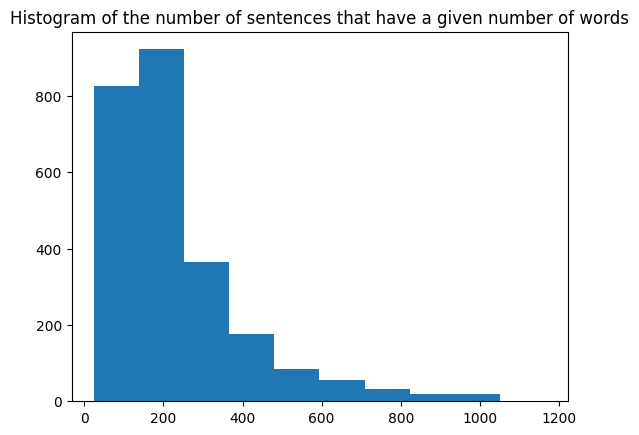

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_hist(X):
    len_ = [len(_) for _ in X]
    plt.hist(len_)
    plt.title('Histogram of the number of sentences that have a given number of words')
    plt.show()
    
plot_hist(X_train)


You will probably see that 90 to 95% of your sentences have less than 300 words. And very few have more than 1000.

However, as you didn't use `maxlen` in your padding above, your input tensor has a dimension equal to the length of the sentence that has the maximum number of words.

Now, let's look at how this affects the padding: 


<img src="tensor_size.png" alt='Word2Vec' width="700px" />

Because of a few of very long sentences, one dimension of your tensor is equal to around 1000. However, most of the sentences with ~200 words have just padded values that are useless.

So your tensor is mostly useless information, which still adds time to the training process.

But what if you pad the data to a maximum length (`maxlen`) of say 200 (words)?
- First, that would increase the convergence and you would not need to stare at your screen while waiting for the algorithm to converge
- But in essence, do you really lose that much information? Do you think that you often need more than 200 words (up to 1000) to tell whether or not a sentence is positive of negative?

❓ **Question** ❓ For all these reasons, re-do your padding using the `maxlen` keyword and retrain the model!  See how much faster it is now - without hurting the performance ;)

In [ ]:
# YOUR CODE HERE